I put the **Dartmouth - Courses.csv** in the "content" folder here in google colab.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns

In [3]:
df = pd.read_csv('Dartmouth - Courses.csv') # name has to be exact

#converting to floats
for col in ['Course Number', 'Number of Sections', 'Enrollments', 'Average Section Size']:
    df[col] = df[col].astype(float)

**Side note:** sure if this is too allowed, but for data imputation I did part of it with a code (going as far as possible using more obvious methods) and part of it using machine learning.  I'm not sure if I was supposed to only use machine learning for this part so apologies if I messed it up.

**Two Helper Methods**

In [4]:
#helper to get previous value if the next one up is invalid/empty
def getPrevious(df, current_index, col):
    index = current_index - 1
    while pd.isna(df.at[index, col]):
      index -= 1
    return df.at[index, col]


#helper to get next value if the next one down is invalid/empty
def getNext(df, current_index, col):
    index = current_index + 1
    while pd.isna(df.at[index, col]):
      index += 1
    return df.at[index, col]

In [5]:
columnsToFix = ['Year', 'Term Number', 'Department', 'Number of Sections', 'Enrollments', 'Average Section Size']

#course number is in numerical order
#Average section = Enrollments/Number of Sections

for col in columnsToFix:
  i = 0 #current index
  while i < len(df):
    if pd.isna(df.at[i, col]):
      if col in ['Year', 'Term Number', 'Department']: # only these for now

        # this looks down, if it's also null, keeps going till it hits a value
        downshift = 1
        while i + downshift < len(df) and pd.isna(df.at[i + downshift, col]):
          downshift += 1

        if i == 0: # this accounts for the edge case where the first value is blank
          for w in range(downshift):
            df.at[i + w, col] = df.at[i + downshift, col]

        # checks if this spot is in between two of the same values
        elif i + downshift < len(df) and df.at[i+downshift, col] == df.at[i - 1, col]:
          for w in range(downshift):
            df.at[i + w, col] = df.at[i - 1, col]

        #year and term number are solved but department seems to still have problems
        # this is just for department in case the two comparing aren't equal
        elif col == 'Department' and df.at[i+downshift, col] != df.at[i - 1, col]:
          if df.at[i - 1, 'Department'] != df.at[i + 1, 'Department']:
            for w in range(downshift):
              i2 = i + w # this is probably inefficient but so that it goes through if there are like 2-3 blanks in a row

              # since the course numbers are ordered numerically this will just check if the current course number is greater or smaller than the previous
              CourseNum = df.at[i2, 'Course Number']
              PrevCourseNum = getPrevious(df, i2, 'Course Number')
              NCourseNum = getNext(df, i2, 'Course Number')

              # logic of where to put
              if CourseNum >= PrevCourseNum:  df.at[i2, 'Department'] = getPrevious(df, i2, 'Department')
              elif CourseNum <= PrevCourseNum:  df.at[i2, 'Department'] = getNext(df, i2, 'Department')
              elif df.at[i - 1, 'Term Number'] != df.at[i, 'Term Number']: # in case the term number changes
                df.at[i2, 'Department'] = df.at[i2 + 1, 'Department']

              # sometimes the current course number is none/NA
              elif NCourseNum >= PrevCourseNum:
                df.at[i2, 'Department'] = getPrevious(df, i2, 'Department')
              elif NCourseNum <= PrevCourseNum:
                df.at[i2, 'Department'] = getNext(df, i2, 'Department')

      # fixing number of sections
      elif col == 'Number of Sections' and not pd.isna(df.at[i, 'Enrollments']) and not pd.isna(df.at[i, 'Average Section Size']):
          df.at[i, 'Number of Sections'] = df.at[i, 'Enrollments'] / df.at[i, 'Average Section Size']

      elif col == 'Enrollments' and not pd.isna(df.at[i, 'Number of Sections']) and not pd.isna(df.at[i, 'Average Section Size']):
          df.at[i, 'Enrollments'] = df.at[i, 'Number of Sections'] * df.at[i, 'Average Section Size']

      elif col == 'Average Section Size' and not pd.isna(df.at[i, 'Enrollments']) and not pd.isna(df.at[i, 'Number of Sections']):
          df.at[i, 'Average Section Size'] = df.at[i, 'Enrollments'] / df.at[i, 'Number of Sections']

      i += downshift # jumps forward

    else:
      i += 1 # or just continues on


#df.to_csv('v5.csv', index=False)

**I plan to get a vocabulary of classes (course #) available for each department and then fill in one of them for the missing Course Number**

In [6]:
# creating a "vocabulary", basically it sorts the dataframe by the Department column 
# then creates a dictionary with the keys as the departments, and unique course numbers as values 
sort_departments = df.sort_values(by='Department')
department_course_numbers = sort_departments.groupby('Department').apply(lambda x: x['Course Number'].dropna().tolist()).to_dict()
for department, courses in department_course_numbers.items():
  department_course_numbers[department] = sorted(courses)

#helper
def findClosestNumbers(lst, previous, next):
   results = [i for i in lst if previous <= i <= next]

   if not results:
      results = [i for i in lst if previous <= i] # if that is null, just tries for one that is larger than this one
   else:
      closest = min(lst, key=lambda x: abs(x - previous)) # else finds the closest to previous
      results.append(closest)

   return results

def fixCourseNumber(df):
  for i in range(len(df)):
    if pd.isna(df.at[i, 'Course Number']):

      # edge case, if this is the first in the table, or the first in a department
      if i == 0 or df.at[i, 'Department'] != df.at[i - 1, 'Department']: prevCourse = 0
      else: prevCourse = getPrevious(df, i, 'Course Number')

      if i == len(df) - 1 or df.at[i, 'Department'] != df.at[i + 1, 'Department']: nextCourse = float('inf')
      else: nextCourse = getNext(df, i, 'Course Number')

      department = df.at[i, 'Department']
      potential_courses = findClosestNumbers(department_course_numbers[department], prevCourse, nextCourse)

      if potential_courses:
          df.at[i, 'Course Number'] = potential_courses[0]  # Picking the first available course number

  return df

df = fixCourseNumber(df)

**KNN IMPUTER**

This takes care of the rest of the missing Median GPA Points

In [7]:
#method to do it multiple times
def impute(df, col):
  # that numerical columns I want to use the imputer on
  # I want to not include Year and Term Number because logically those shouldn't affect GPA much and I don't want the KNN imputer to have to factor those in
  cols = ["Department", 'Course Number', 'Number of Sections', 'Enrollments', 'Median GPA Points', 'Average Section Size']
  df_selected = df[cols]

  # One-hot encode the values in department so each unique string in Department gets their own column for 0 and 1
  df_encoded = pd.get_dummies(df_selected, columns=['Department'], drop_first=False)

  imputer = KNNImputer(n_neighbors=2) # I feel like lower neighbor numbers would be better since there are not so many "close" values
  df_encoded_imputed = imputer.fit_transform(df_encoded)

  # Convert back to dataframe
  df_imputed = pd.DataFrame(df_encoded_imputed, columns=df_encoded.columns)
  return df_imputed[col]

df['Median GPA Points'] = impute(df, 'Median GPA Points')


**Note:** I had to be careful about enrollments, since Enrollments should ALWAYS be =  Number of Sections * Average Sections Size, and an imputer from sklearn wouldn't necessarily follow that.  


I also chose the KNN imputer as opposed to a simple (that would like just take the average) or iterative imputer because I felt it would be more effective if the imputing algorithm was trained on the closest points rather than a bunch


KNN Imputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

Iterative Imputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

From my understanding, these imputer regression models are trained independent of the one I will try to train the data on so it hopefully won't affect the model I make





In [8]:
# have to be careful about enrollments, should ALWAYS be Number of Sections * Average Sections Size

# have to do it again, FIRST for number of sections
df['Number of Sections'] = impute(df, 'Number of Sections')
df['Number of Sections'] = np.ceil(df['Number of Sections']) # round up, can't have 1.5 sections

# fill in enrollments if there is an average section size
for i in range(len(df)):
  if pd.isna(df.at[i, 'Enrollments']) and not pd.isna(df.at[i, 'Average Section Size']): # if there is a average section size
    df.at[i, 'Enrollments'] = df.at[i, 'Number of Sections'] * df.at[i, 'Average Section Size']



# next for the enrollment column
df['Enrollments'] = impute(df, 'Enrollments')
df['Enrollments'] = np.ceil(df['Enrollments']) # round up, can't have like 12.5 people enrolled

# fill in average section size
for i in range(len(df)):
  if pd.isna(df.at[i, 'Average Section Size']): # if there is a average section size
    df.at[i, 'Average Section Size'] = df.at[i, 'Enrollments'] / df.at[i, 'Number of Sections']


#df.to_csv('imputedGraph.csv', index = False)

**DONE IMPUTING DATA! (this took me forever)**

Initial Ideas for Maybe What to Observe:

- Maybe guess the department?
- Guess the median GPA points? (Would have to compare against just guessing all 4's since that is the mode)
- Guess the average Section size? (Would have to drop the number of enrollments and number of sections.  Maybe provide the algorithm with the average number of enrollments for each dept, but that could still be biased?)

I tried plotting some data to see potential correlations?

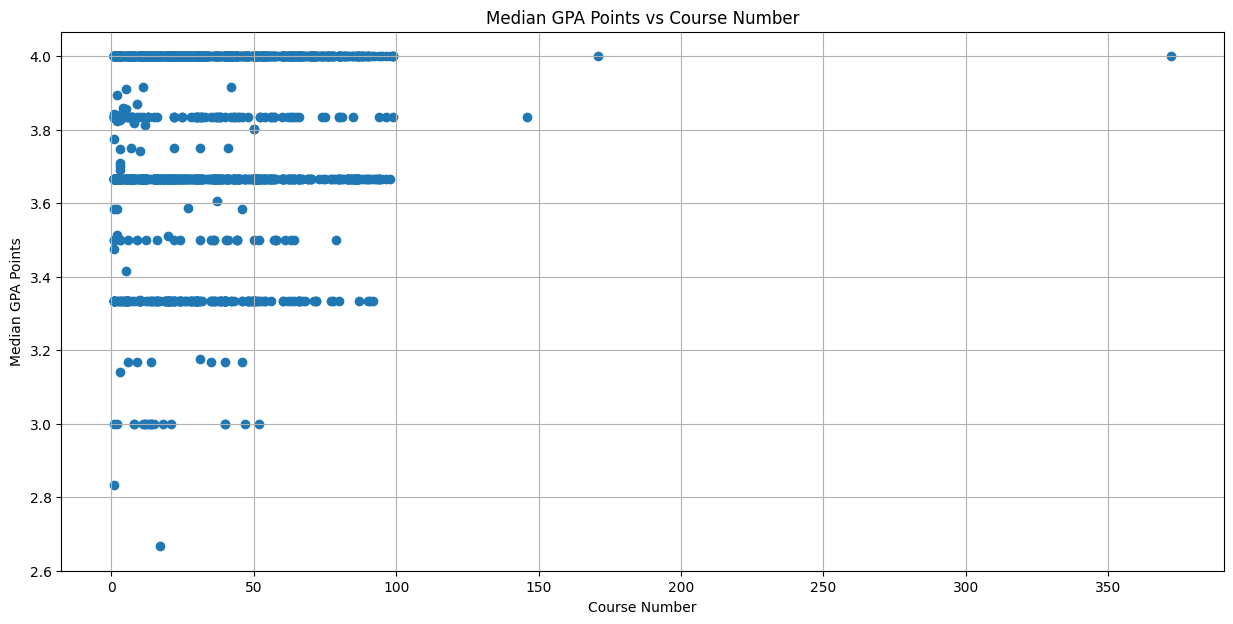

In [10]:
# plotting some of the data to explore interpretations

plt.figure(figsize=(15, 7))
plt.scatter(df['Course Number'], df['Median GPA Points'])
plt.xlabel('Course Number')
plt.ylabel('Median GPA Points')
plt.title('Median GPA Points vs Course Number')
plt.grid(True)
plt.show()

**For Above:** There doesn't seem to be a significant correlation between Course # and Median GPA but its interesting that most of the lower Median GPA points are actually on earlier or more prerequisite steps (which goes against what I thought).

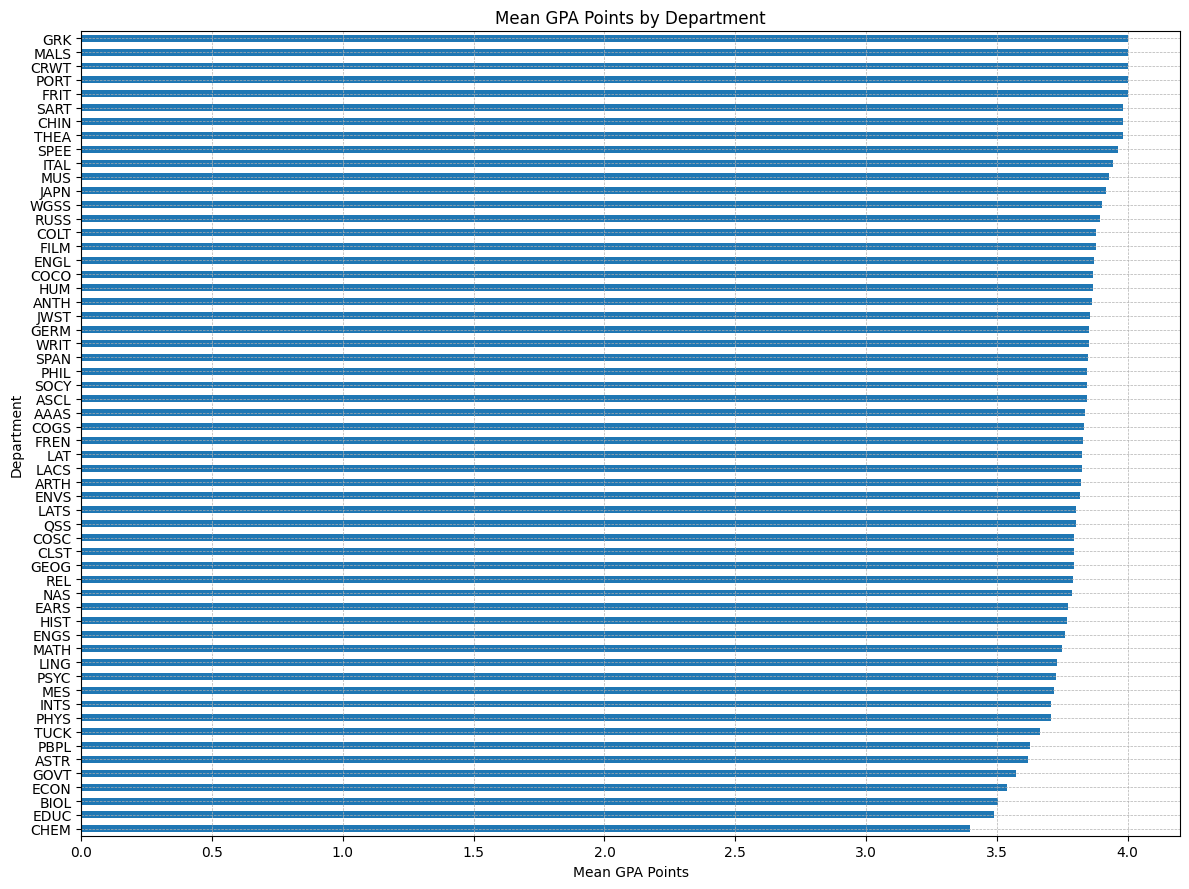

In [11]:
# Calculate the mean GPA for each department
department_medians = df.groupby('Department')['Median GPA Points'].mean()

# sort
department_medians = department_medians.sort_values()

plt.figure(figsize=(12, 9))
department_medians.plot(kind='barh')
plt.xlabel('Mean GPA Points')
plt.ylabel('Department')
plt.title('Mean GPA Points by Department')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


**For Above:** Each of the departments does seem to have a distinct average but then again there is likely a large discorrelation within the departments so this statistic might be too much

# **CREATING MODEL**

In hindsight, trying to create a model to predict average medians (where I arguably should have done the reverse and used the median as an important feature) probably wasn't the best idea since there really didn't seem to be any statistical information showing it.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

if 'Unnamed: 0' in df.columns: # if it's there, in case you run the program multiple times
  df = df.drop(columns=['Unnamed: 0'])

# features I want to scale
scale_features = ['Year', 'Term Number', 'Course Number', 'Number of Sections', 'Enrollments', 'Average Section Size']

# one hot code Department
# this will convert labels to one-hot encoded format
# representation of variables in a binary vector, each unique value gets its own column
data = pd.get_dummies(df, columns=['Department'], prefix='Dept')

# Create interaction features)

X = data.drop(columns=['Median GPA Points'])
y = data['Median GPA Points']

In [14]:
# using sklearn to split the data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

In [17]:
X_train.head() #test, clearly the numerical values have been scaled and the department column has been one hot encoded

,Year,Term Number,Course Number,Number of Sections,Enrollments,Average Section Size,Dept_AAAS,Dept_ANTH,Dept_ARTH,Dept_ASCL,...,Dept_REL,Dept_RUSS,Dept_SART,Dept_SOCY,Dept_SPAN,Dept_SPEE,Dept_THEA,Dept_TUCK,Dept_WGSS,Dept_WRIT
845,0.761411,-1.144757,2.007590,-0.178420,-0.402498,-0.697270,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1214,0.761411,-0.285673,-0.807432,1.677146,0.364845,-0.400501,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1550,0.761411,-0.285673,0.237303,-0.178420,-0.256337,-0.301579,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
774,0.761411,-1.144757,0.459580,-0.178420,-0.365958,-0.598347,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1259,0.761411,-0.285673,0.490201,-0.178420,-0.420768,-0.746732,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad  # implementing optimizer


In [19]:
# added L1 and L2 regularization to help against overfitting

def createModel(units=32, units2=64, dropout_rate=0.3, l1=0.005, l2=0.005, learning_rate=0.001):
  model = Sequential()
  model.add(Dense(units=units, activation='relu', input_dim=len(X_train.columns), kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
  model.add(Dropout(dropout_rate))  # adding dropout
  model.add(Dense(units=units2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1, activation='linear'))

  optimizer_instance = Adam(learning_rate=0.001)  # You can adjust the learning rate or other parameters

  # mean squared error
  # adam optimizer
  model.compile(loss='mean_squared_error', optimizer=optimizer_instance, metrics=['mae'])

  return model

model = createModel()

In [20]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
32/32 [==============================] - 1s 11ms/step - loss: 12.9247 - mae: 3.0957 - val_loss: 8.9426 - val_mae: 2.3586
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 6.9916 - mae: 1.7794 - val_loss: 4.4468 - val_mae: 1.1123
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 4.3901 - mae: 1.0101 - val_loss: 3.1778 - val_mae: 0.5946
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 3.5570 - mae: 0.8006 - val_loss: 2.8273 - val_mae: 0.5222
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 3.3655 - mae: 0.7816 - val_loss: 2.5956 - val_mae: 0.5023
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 3.0345 - mae: 0.7334 - val_loss: 2.3912 - val_mae: 0.4831
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 2.8985 - mae: 0.7394 - val_loss: 2.1931 - val_mae: 0.4389
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 2.4924 - mae: 0.

In [21]:
# testing it with just getting the median

def testWithMedian(model, X_test):
  medianGPA = df['Median GPA Points'].median()
  print("Median GPA: " + str(medianGPA))

  num_test_samples = len(df)

  baseline_predictions = pd.DataFrame({'Median GPA Points': [medianGPA] * num_test_samples})
  baseline_predictions = pd.DataFrame({'Median GPA Points': [medianGPA] * len(y_test)})

  model_predictions = model.predict(X_test)

  # Now you have the MAE for both the model and the baseline
  print("Model MAE:", mean_absolute_error(y_test, model_predictions))
  print("Baseline MAE:", mean_absolute_error(y_test, baseline_predictions))

testWithMedian(model, X_test)

Median GPA: 3.8333333333333335
10/10 [==============================] - 0s 2ms/step
Model MAE: 0.22094621920752003
Baseline MAE: 0.2055098286812457


**Initial Findindings:**
Before hyperparameter tuning, it seems that my model performs no better than just predicting the median GPA everytime.

# **HYPERPARAMETER TUNING**

I emploed grid search to do my hyperparameter tuning, so I essentially just had the model test a bunch of different hyperparameter settings that I set and save the best one.

The hyperparameters I tuned were:
- number of units in first layer
- l1 and l2 values in the first layer
- first dropout rate
- l1 and l2 values in the second layer
- second dropout rate
- learning rate in Adam optimizer


In [22]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.2 MB/s eta 0:00:00


In [25]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error

# builds a keras model
# this is basically like the method I made earlier, except it uses hp.__ to provide a min and max
# instead of inputting a parameter
def buildKerasModel(hp):
    model = Sequential()
    model.add(layers.Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu',
        input_dim=len(X_train.columns),
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1', min_value=0.001, max_value=0.01, sampling='log'),
            l2=hp.Float('l2', min_value=0.001, max_value=0.01, sampling='log')
        )
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)))
    model.add(layers.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1', min_value=0.001, max_value=0.01, sampling='log'),
            l2=hp.Float('l2', min_value=0.001, max_value=0.01, sampling='log')
        )
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))

    optimizer_instance = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.01, sampling='log'))
    model.compile(loss='mean_squared_error', optimizer=optimizer_instance, metrics=['mae'])
    return model


# Define a Keras Tuner RandomSearch tuner and specify the search space for hyperparameters
tuner = kt.RandomSearch(
    buildKerasModel,
    objective='val_loss',
    max_trials=20, # stops after 20 trials
    directory='Tuning',
    project_name='Projects'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# retrieve the best hyperparameters and best model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

best_model.fit(X_train, y_train, epochs=50, batch_size=32)

# eval best and print
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Best Model MSE:", mse)
print("Best Model MAE:", mae)

Reloading Tuner from Tuning/Projects/tuner0.json
Epoch 1/50
39/39 [==============================] - 1s 2ms/step - loss: 3.7644 - mae: 1.3688
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 1.4233 - mae: 0.7427
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.9039 - mae: 0.5583
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.6375 - mae: 0.4545
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5094 - mae: 0.4112
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4606 - mae: 0.4259
Epoch 7/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4199 - mae: 0.4222
Epoch 8/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4051 - mae: 0.4359
Epoch 9/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3492 - mae: 0.4078
Epoch 10/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3257 - mae: 0.4061
Epoch 11/50
39/39 [=

In [26]:
testWithMedian(best_model, X_test)  # comparing with the "median" model/process

Median GPA: 3.8333333333333335
10/10 [==============================] - 0s 2ms/step
Model MAE: 0.21765749268616658
Baseline MAE: 0.2055098286812457


My model: 0.21765749268616658

Mean model: **0.2055098286812457**

Used MAE or mean absolute error to evaluate the difference.

**Conclusion:** Well, despite all my efforts, my model couldn't outperform just picking the median of the entire GPA column, which could either mean there is really no correlation in the data (which is what I think), or that my model is flawed.